# Введение в нейронные сети

## Урок 6. Сегментация

### Практическое задание

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

### Решение

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

from tensorflow.keras.datasets import imdb

#### Глобальные настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Путь к изображениям и маскам.
PATH_DATASET = '\\clothing-co-parsing-master\photos\\'
PATH_MASKS = '\\clothing-co-parsing-master\\annotations\\pixel-level\\'

#### Загрузка и подготовка датасета clothing-co-parsing-master

In [3]:
# Обработка изображений: нормализация и изменение размера.
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (128, 128))
    return image 
     
# Обработка масок: нормализация и изменение размера.
def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [4]:
%%time

images = []
masks = []

# Загрузка изображений и масок.
for mask_filename in os.listdir(os.getcwd() + PATH_MASKS):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(os.getcwd() + PATH_DATASET + image_filename))
    images.append(preprocess_image(image))

    mask_file = io.loadmat(os.getcwd() + PATH_MASKS + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth']) 
    masks.append(preprocess_mask(mask))

Wall time: 8.92 s


In [5]:
# Разбиение и подготовка данных.
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

sample_image, sample_mask = X_train[0], y_train[0]

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train = tf.data.Dataset.zip((X_train, y_train))
test = tf.data.Dataset.zip((X_test, y_test)) 

In [6]:
# Функции для аугментации:
# - яркость;
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# - оттенок;
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# - отзеркаливание по горизонтали.
def flip_horisontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [7]:
%%time

# Последовательно применяем аугментации.
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

Wall time: 78.8 ms


#### Функции для визуализации

In [8]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#### Построение нейросети

In [9]:
# Параметры нейросети.
tf.random.set_seed(0)
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE)

In [10]:
# Загрузка предобученной модели.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Слои для сжатия изображения.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [11]:
# Слои для восстановления изображения.
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False, activation='relu')
]

In [12]:
def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Сжатие изоражения.
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Восстановление изображения и skip-connections.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # Выходной слой.
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
%%time

# Сборка модели.
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Wall time: 272 ms


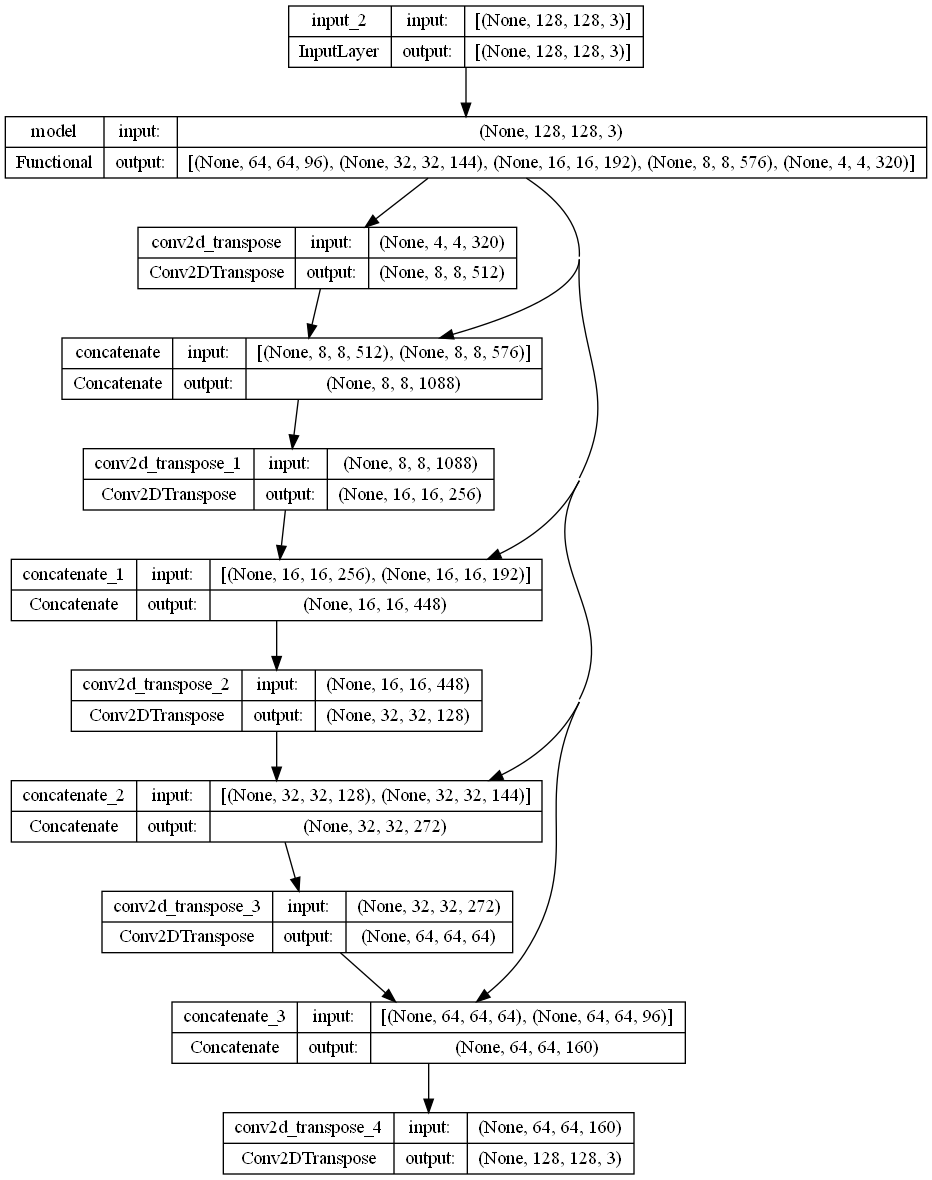

In [14]:
# Граф собранной модели.
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 [==============================] - 0s 487ms/step


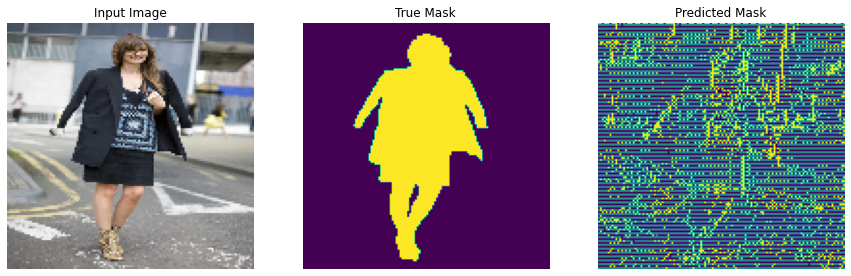

In [15]:
# Вывод прогноза предобученной модели.
show_predictions(model)

#### Обучение

Epoch 1/5
1/1 [==============================] - 0s 20ms/step- loss: 0.1731 - accuracy: 0.92


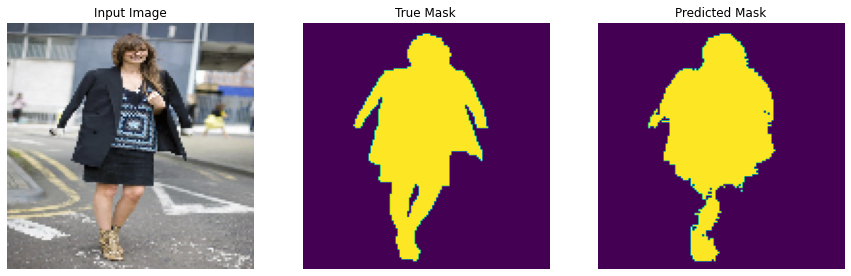


Sample Prediction after epoch 1

201/201 [==============================] - 89s 436ms/step - loss: 0.1731 - accuracy: 0.9277 - val_loss: 0.1006 - val_accuracy: 0.9598
Epoch 2/5
1/1 [==============================] - 0s 21ms/step- loss: 0.0756 - accuracy: 0.97


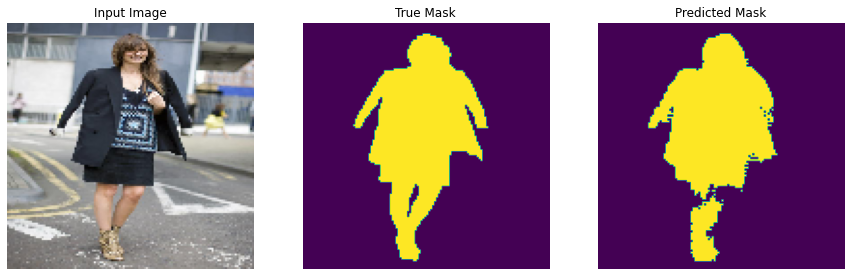


Sample Prediction after epoch 2

201/201 [==============================] - 90s 449ms/step - loss: 0.0756 - accuracy: 0.9702 - val_loss: 0.0881 - val_accuracy: 0.9661
Epoch 3/5
1/1 [==============================] - 0s 23ms/step- loss: 0.0583 - accuracy: 0.97


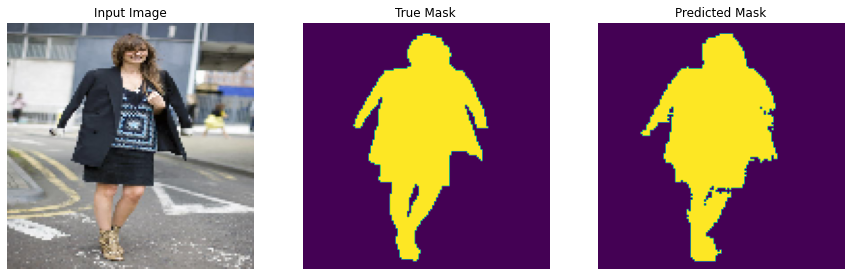


Sample Prediction after epoch 3

201/201 [==============================] - 87s 433ms/step - loss: 0.0583 - accuracy: 0.9772 - val_loss: 0.0778 - val_accuracy: 0.9713
Epoch 4/5
1/1 [==============================] - 0s 23ms/step- loss: 0.0478 - accuracy: 0.98


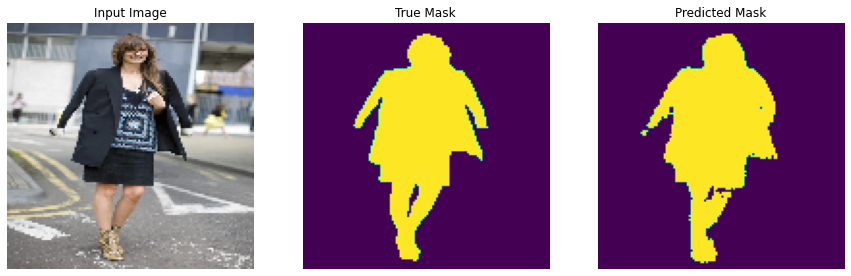


Sample Prediction after epoch 4

201/201 [==============================] - 88s 436ms/step - loss: 0.0478 - accuracy: 0.9813 - val_loss: 0.0795 - val_accuracy: 0.9721
Epoch 5/5
1/1 [==============================] - 0s 22ms/step- loss: 0.0403 - accuracy: 0.98


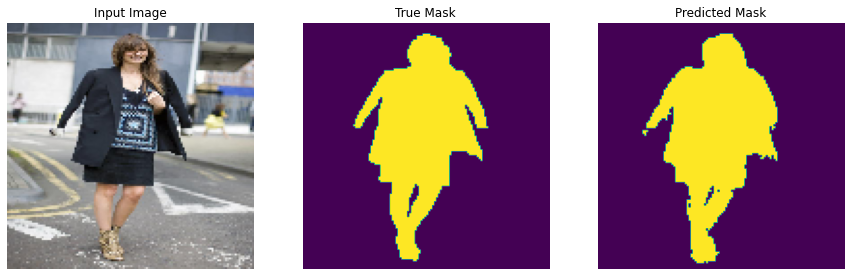


Sample Prediction after epoch 5

201/201 [==============================] - 90s 445ms/step - loss: 0.0403 - accuracy: 0.9841 - val_loss: 0.0850 - val_accuracy: 0.9719
Wall time: 7min 24s


In [16]:
%%time

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 5

model_history = model.fit(train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

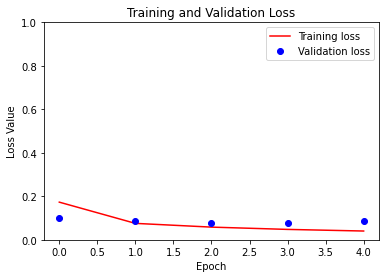

In [17]:
# Визуализация функции потерь на обучающей и тестовой выборках.
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 270ms/step


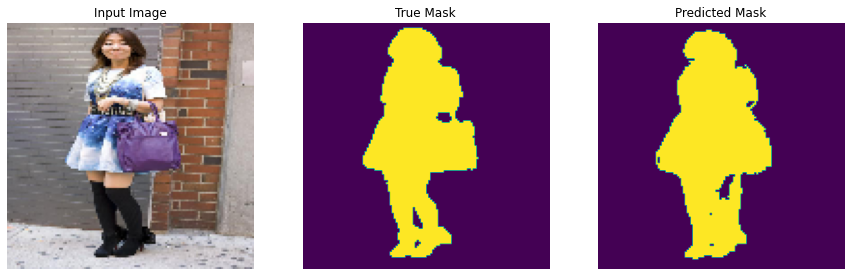

1/1 [==============================] - 0s 258ms/step


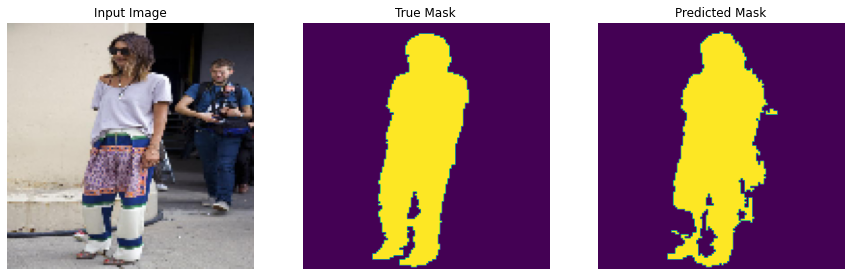

1/1 [==============================] - 0s 267ms/step


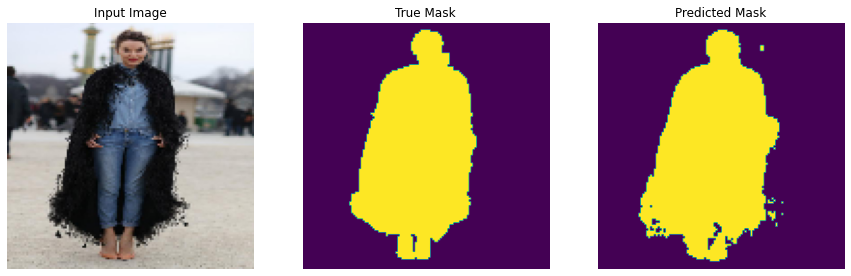

In [19]:
show_predictions(model, test, 3)

#### Выводы

Построенная модель демонстрирует небольшое переобучение, так как на последних итерациях функция потерь начала незначительно увеличиваться. При этом наблюдается хорошая точность прогнозирования: 98% и 97% на обучающей и валидационной выборках соответственно.

Построение и применение модели показывают, что решению задачи сегментации способствуют достаточное число слоёв для сжатия и восстановления изображения. Также стоит упомянуть технику "skip-connections", которая препятствует затуханию градиента и позволяет получить модели дополнительную информацию в процессе восстановления исходного изображения.

Особенно важна плавность сжатия и восстановления, которая достигается при равномерном уменьшении и увеличении размерностей слоёв. При этом более сложные задачи сегментации требуют большей плавности при большем числе слоёв и, как следствие, больших вычислительных мощностей.